In [12]:
import glob
import numpy as np
import pandas as pd

first = True

# Import all the datasets
for filepath in glob.iglob(r'./data/HMEC122L*.tsv'):
    newData = pd.read_csv(filepath, delimiter="\t", index_col=["Ligand", "ECMp"])

    if first:
        data = newData
        first = False
    else:
        data = data.join(newData, how="inner", lsuffix=filepath)

data = data.reset_index()
data = data.dropna(axis=1)
data.drop(list(data.filter(regex = '.tsv')), axis = 1, inplace = True)
data.drop(list(data.filter(regex = '_SE')), axis = 1, inplace = True)
data.drop(list(data.filter(regex = 'Feret')), axis = 1, inplace = True)
data.drop(list(data.filter(regex = 'Gated')), axis = 1, inplace = True)
data.drop(list(data.filter(regex = 'Norm')), axis = 1, inplace = True)
data.drop(list(data.filter(regex = 'Conc')), axis = 1, inplace = True)

In [13]:
measurements = data.columns[data.dtypes == float]
tensor = np.empty((pd.unique(data["Ligand"]).size, pd.unique(data["ECMp"]).size, len(measurements)))

for ii, ECM in enumerate(pd.unique(data["ECMp"])):
    dataECM = data.loc[data["ECMp"] == ECM, :]

    for jj, ligs in enumerate(pd.unique(data["Ligand"])):
        selected = dataECM.loc[dataECM["Ligand"] == ligs, measurements]

        tensor[jj, ii, :] = selected.iloc[0, :]

tensor -= np.mean(tensor, axis=(0, 1), keepdims=True)
assert np.all(np.isfinite(tensor))
tensor /= np.std(tensor, axis=(0, 1), keepdims=True)

goods = np.all(np.isfinite(tensor), axis=(0, 1))
measurements = measurements[goods]
tensor = tensor[:, :, goods]

In [14]:
import tensorly as tl
from tensorly.cp_tensor import cp_flip_sign
from tensorly.decomposition import parafac

fac = parafac(tensor, 5, n_iter_max=2000, linesearch=True, tol=1e-8)

fac = cp_flip_sign(fac, 2)
fac.normalize()

facZero = pd.DataFrame(fac.factors[0], index=pd.unique(data["Ligand"]))
facOne = pd.DataFrame(fac.factors[1], index=pd.unique(data["ECMp"]))
facTwo = pd.DataFrame(fac.factors[2], index=measurements)

print(1.0 - np.linalg.norm(tl.cp_to_tensor(fac) - tensor)**2.0 / np.linalg.norm(tensor)**2.0)
print(np.sum(tensor.shape) * fac.rank / tensor.size)

0.5269191901028802
0.004420538960012644


In [18]:
tensor.shape

(57, 48, 74)

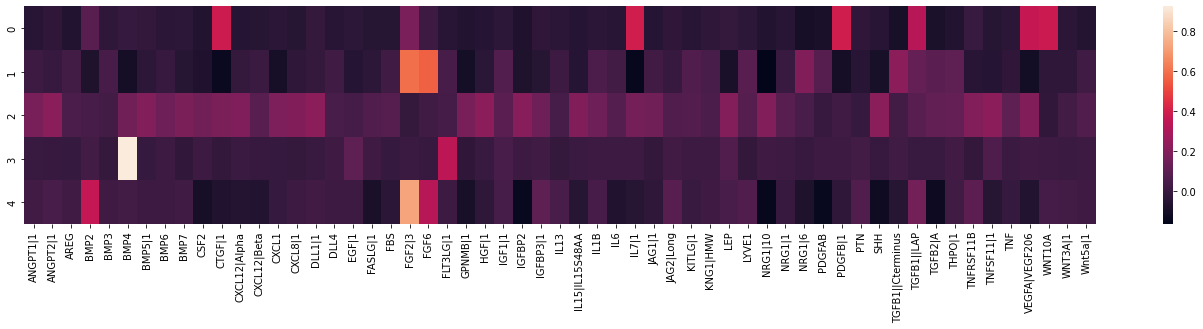

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [24, 4]

sns.heatmap(facZero.T);

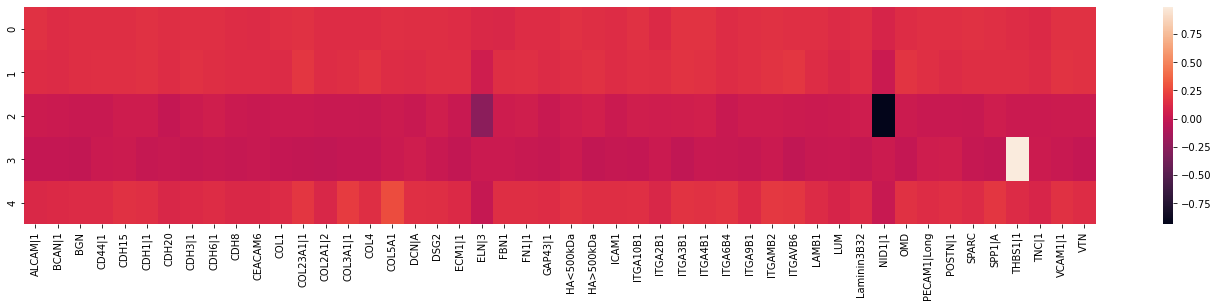

In [16]:
sns.heatmap(facOne.T);

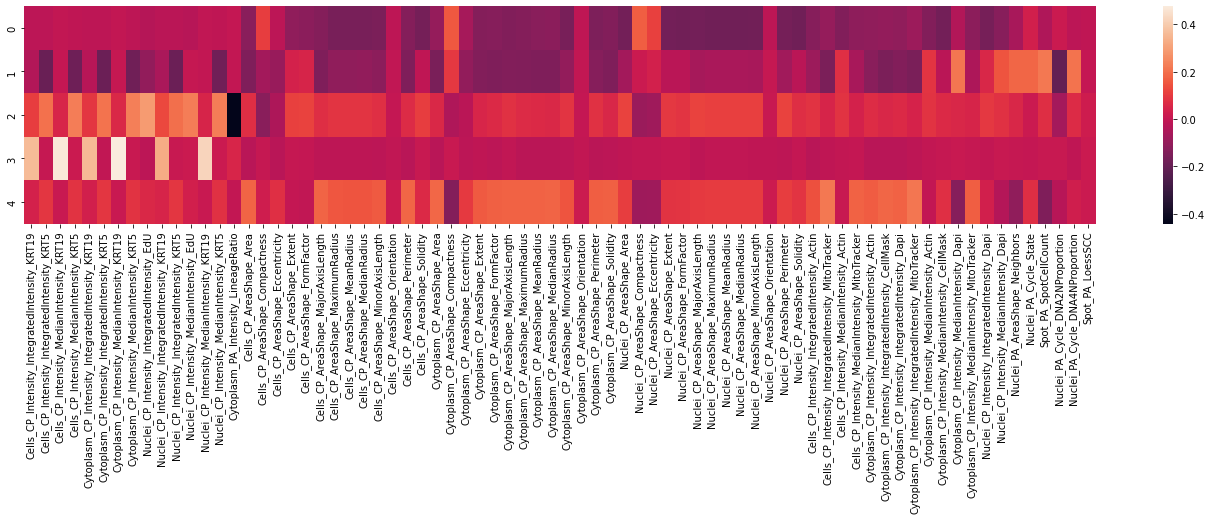

In [17]:
sns.heatmap(facTwo.T);